# Lógica Computacional
#### Grupo 20
* Francisco Domingos Martins Oliveira,  A82066
* José Luís Cerqueira Pires, A84552

## Trabalho Prático 2
Vamos começar por importar as ferramentas necessárias em todo o Notebook.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from z3 import *

## Exercício 2

Primeiramente, vamos definir as funções que nos vão ajudar a calcular os valores conforme formos percorrendo o grafo.

In [ ]:
n=16
def l_shift_rot(c, r):
    return((c<<r) | LShR(c,16-r))

# Bitwise Exclusive XOR
def xor (x, y):
    return x^y
# sum 
def soma(x, y):
    return x+y


De seguida criamos a função para solucionar o problema.
Começamos por inverter o grafo.
Ao percorre-lo, verificamos a que $gate$ um dado vértice está associado. Se for uma soma ou um xor, guardamos em duas variaveis os dois vértices vizinhos e adicionamos ao solver a operação encontrada entre as variaveis binarias formadas pelo vertice em questao e os vertives vizinhos: $x_{v,vizinho_1}$ , $x_{v,vizinho_2}$
Caso seja, um $left shift rotate$ ou $wire$ só existirá um vizinho. Mas o processo, é análogo.


In [2]:

def graph_solver(graph):
    graph = nx.DiGraph.reverse(graph)
    s = Solver()
    x= {}
    
    # incializar as variáveis em z3 
    for a, b in graph.edges:
        if "peso" in graph.edges[a,b]:
            x[a,b] = graph.edges[a,b]["peso"]
        else:
            x[a,b] = BitVec(str(a)+str(b), n)
    for a,b in graph.edges:
        aresta= x[a,b]
        if graph.nodes[b]["op"] == "xor": 
            vizinhos=list(graph.neighbors(b))
            vizinho1 = vizinhos[0]
            vizinho2= vizinhos[1]
            t=(xor(x[b,vizinho1],x[b,vizinho2]))
            s.add(t>0)
            s.add (t == aresta)
        elif graph.nodes[b]["op"] == "soma":
            vizinhos=list(graph.neighbors(b))
            vizinho1 = vizinhos[0]
            vizinho2 = vizinhos[1]
            t=(soma(x[b,vizinho1],x[b,vizinho2]) )
            s.add (t == aresta)
            # soma >0 para nao ser trivial pode se remove
            s.add (t >0)
        elif graph.nodes[b]["op"] == "lshr":
            vizinhos=list(graph.neighbors(b))
            vizinho = vizinhos[0]
            shiftv=graph.nodes[b]["rotate"]
            t=l_shift_rot(x[b,vizinho],shiftv)
            s.add (aresta == t)
        elif graph.nodes[b]["op"] == "wire":
            vizinhos=list(graph.neighbors(b))
            t = vizinhos[0]
            s.add(aresta==t)
            

    if s.check() == sat:
        m = s.model()
        for a,b in x:
            #colocar os valores finais no grafo 
            if m[x[a,b]] != None:
                graph.edges[a,b]["peso"] = m[x[a,b]]
        sol = nx.DiGraph.reverse(graph)
        return sol
    else:
        return 'NULL'
        
    

Criamos também uma função para desenhar o grafo:

In [3]:
def draw_graph (graph):
    nodes = {}
    
    for i in graph.nodes:
        if graph.nodes[i]["op"] == "out":
            nodes[i] = "out"
        elif graph.nodes[i]["op"] == "xor":
            nodes[i] = "xor"
        elif graph.nodes[i]["op"] == "soma":
            nodes[i] = "+"
        elif graph.nodes[i]["op"] == "lshr":
            nodes[i] = "<<" + str(graph.nodes[i]["rotate"])
        elif graph.nodes[i]["op"] == "in":
            nodes[i] = "in"
        elif graph.nodes[i]["op"] == "wire":
            nodes[i] = "wire"
    
    
    labels = {}
    for a,b in graph.edges():
        if "peso" in graph.edges[a,b]:
            labels[(a,b)]= graph.edges[a,b]["peso"]

            

    
            
    pos = nx.nx_pydot.graphviz_layout(graph)
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    nx.draw(graph, font_size=10, pos=pos, labels=nodes)
    nx.draw_networkx_edge_labels(graph, pos, labels)
    plt.show()

Alguns exemplos do funcionamento do programa: 

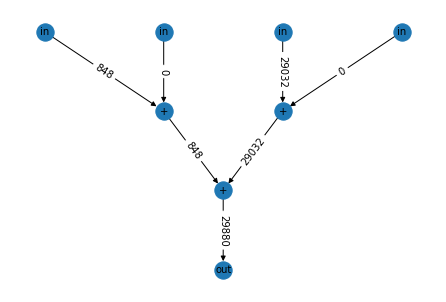

In [4]:
n = 16

G = nx.DiGraph()
G.add_nodes_from([i for i in range(8)])
G.add_edges_from([(1, 0), (2, 1), (3, 1), (6, 3), (4, 2), (5, 2), (7, 3)])
G.nodes[0]["op"] = "out"
G.edges[1,0]["peso"] = BitVecVal(np.random.randint(2**16), 16) 
for i in [1,2, 3]:
    G.nodes[i]["op"] = "soma"
for i in [4, 5, 6, 7]:
    G.nodes[i]["op"] = "in"


G = graph_solver(G)
while(True):
    if(G!='NULL'):
        draw_graph(G)
        break 

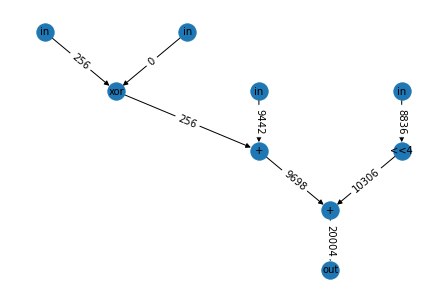

In [5]:
n = 16

G = nx.DiGraph()
G.add_nodes_from([i for i in range(9)])
G.add_edges_from([(1, 0), (2, 1), (3, 1), (6, 2), (4, 2), (5, 3), (8, 4),(7,4)])
G.nodes[0]["op"] = "out"
G.edges[1,0]["peso"] = BitVecVal(np.random.randint(2**16), 16) 
for i in [1,2]:
    G.nodes[i]["op"] = "soma"
for i in [4]:
    G.nodes[i]["op"] = "xor"
for i in [5, 6, 7, 8]:
    G.nodes[i]["op"] = "in"
for i in [3]:
    G.nodes[i]["op"] = "lshr"
    G.nodes[i]["rotate"]=np.random.randint(1,16)


G = graph_solver(G)
while(True):
    if(G!='NULL'):
        draw_graph(G)
        break 

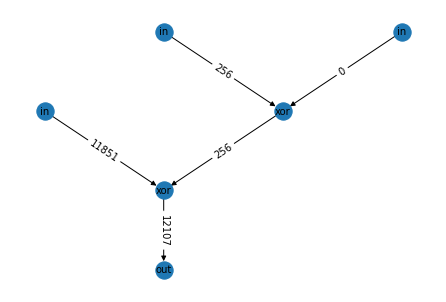

In [6]:
n = 16

G = nx.DiGraph()
G.add_nodes_from([i for i in range(6)])
G.add_edges_from([(1, 0), (2, 1), (3, 1),(4,3),(5,3)])
G.nodes[0]["op"] = "out"
G.edges[1,0]["peso"] = BitVecVal(np.random.randint(2**16), 16) 
for i in [1,3]:
    G.nodes[i]["op"] = "xor"
for i in [2, 4,5]:
    G.nodes[i]["op"] = "in"



G = graph_solver(G)
while(True):
    if(G!='NULL'):
        draw_graph(G)
        break 